In [9]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings 
warnings.filterwarnings('ignore')

In [10]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

# some symbols contain '.' which causes error when downloading data from yfinance
sp500['Symbol'] = sp500['Symbol'].str.replace('.','-') 

symbols_list = sp500['Symbol'].unique().tolist() # Not surviourship bais free

end_date = '2024-06-30'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8) # 8 years ago

df = yf.download(tickers=symbols_list, 
                 start = start_date, 
                 end = end_date).stack() # stack() creates multi-index

df.index.names = ['date','ticker']

df.columns = df.columns.str.lower()

df

[*********************100%%**********************]  503 of 503 completed

1 Failed download:
['SW']: YFChartError("%ticker%: Data doesn't exist for startDate = 1467432000, endDate = 1719720000")


Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-07-05 A        41.086147   43.750000   44.349998   43.630001   44.310001   
           AAL      27.802408   28.930000   29.160000   28.190001   29.090000   
           AAPL     21.811762   23.747499   23.850000   23.615000   23.847500   
           ABBV     43.881741   61.919998   62.709999   61.770000   62.500000   
           ABT      34.040833   39.439999   39.560001   39.209999   39.310001   
...                       ...         ...         ...         ...         ...   
2024-06-28 XYL     135.630005  135.630005  137.990005  134.300003  136.639999   
           YUM     132.460007  132.460007  132.990005  131.720001  132.509995   
           ZBH     108.529999  108.529999  109.580002  107.379997  108.550003   
           ZBRA    308.929993  308.929993  314.040009  306.160004  309.000000   
           ZTS     173.360001  173.360001  177.070007  173.029999  176.460007   

Price                   volume  
date       ticker               
2016-07-05 A         1813500.0  
           AAL       9467000.0  
           AAPL    110820800.0  
           ABBV      6293600.0  
           ABT      10029300.0  
...                        ...  
2024-06-28 XYL       2197600.0  
           YUM       5819000.0  
           ZBH       2774600.0  
           ZBRA       417900.0  
           ZTS       4189600.0  

[989314 rows x 6 columns]

## Calculate features and technical inidcators

<Axes: xlabel='date'>

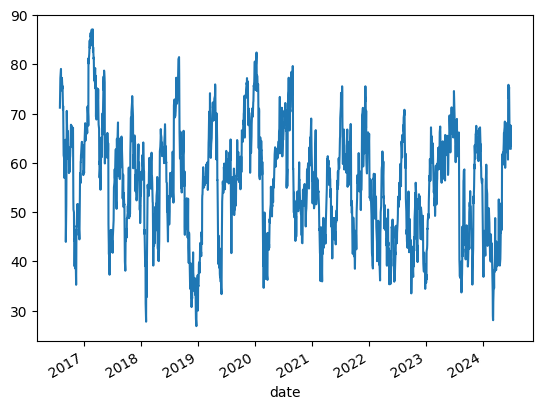

In [11]:
# Garman-Klass volatility estimates the volality of a stock
df[('garman_klass_vol')] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

# Relative Strength Index measures the strength and momentum of a price trend
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df.xs('AAPL',level=1)['rsi'].plot()

In [12]:
# Bollinger Band
# want to normalize and scale the indicator so we supply the log of the closed price

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length = 20).iloc[:,0])

df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length = 20).iloc[:,1])

df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length = 20).iloc[:,2])

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-07-05 A        41.086147   43.750000   44.349998   43.630001   44.310001   
           AAL      27.802408   28.930000   29.160000   28.190001   29.090000   
           AAPL     21.811762   23.747499   23.850000   23.615000   23.847500   
           ABBV     43.881741   61.919998   62.709999   61.770000   62.500000   
           ABT      34.040833   39.439999   39.560001   39.209999   39.310001   
...                       ...         ...         ...         ...         ...   
2024-06-28 XYL     135.630005  135.630005  137.990005  134.300003  136.639999   
           YUM     132.460007  132.460007  132.990005  131.720001  132.509995   
           ZBH     108.529999  108.529999  109.580002  107.379997  108.550003   
           ZBRA    308.929993  308.929993  314.040009  306.160004  309.000000   
           ZTS     173.360001  173.360001  177.070007  173.029999  176.460007   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-07-05 A         1813500.0         -0.002070        NaN       NaN   
           AAL       9467000.0         -0.000219        NaN       NaN   
           AAPL    110820800.0         -0.003027        NaN       NaN   
           ABBV      6293600.0         -0.048204        NaN       NaN   
           ABT      10029300.0         -0.007962        NaN       NaN   
...                        ...               ...        ...       ...   
2024-06-28 XYL       2197600.0          0.000346  45.676162  4.915082   
           YUM       5819000.0          0.000046  39.819102  4.880761   
           ZBH       2774600.0          0.000206  35.442075  4.654188   
           ZBRA       417900.0          0.000323  52.479117  5.693582   
           ZTS       4189600.0          0.000145  52.980608  5.120666   

Price                bb_mid   bb_high  
date       ticker                      
2016-07-05 A            NaN       NaN  
           AAL          NaN       NaN  
           AAPL         NaN       NaN  
           ABBV         NaN       NaN  
           ABT          NaN       NaN  
...                     ...       ...  
2024-06-28 XYL     4.937657  4.960231  
           YUM     4.923641  4.966522  
           ZBH     4.704769  4.755350  
           ZBRA    5.721439  5.749296  
           ZTS     5.158528  5.196390  

[989314 rows x 11 columns]

In [15]:
# The Average True Range calculates the average range between 
# the high and low prices over a specified period of time

def compute_atr(stock_data):
    atr = pandas_ta.atr(high = stock_data['high'],
                        low = stock_data['low'],
                        close = stock_data['close'],
                        length = 14)
    return atr.sub(atr.mean()).div(atr.std())

# group_keys=False prevents it from doubling the date column
df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

# Moving Average Convergence Divergence used to identify potential trend reversals

def compute_macd(close):
    macd = pandas_ta.macd(close=close, lenght=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-07-05 A        41.086147   43.750000   44.349998   43.630001   44.310001   
           AAL      27.802408   28.930000   29.160000   28.190001   29.090000   
           AAPL     21.811762   23.747499   23.850000   23.615000   23.847500   
           ABBV     43.881741   61.919998   62.709999   61.770000   62.500000   
           ABT      34.040833   39.439999   39.560001   39.209999   39.310001   
...                       ...         ...         ...         ...         ...   
2024-06-28 XYL     135.630005  135.630005  137.990005  134.300003  136.639999   
           YUM     132.460007  132.460007  132.990005  131.720001  132.509995   
           ZBH     108.529999  108.529999  109.580002  107.379997  108.550003   
           ZBRA    308.929993  308.929993  314.040009  306.160004  309.000000   
           ZTS     173.360001  173.360001  177.070007  173.029999  176.460007   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-07-05 A         1813500.0         -0.002070        NaN       NaN   
           AAL       9467000.0         -0.000219        NaN       NaN   
           AAPL    110820800.0         -0.003027        NaN       NaN   
           ABBV      6293600.0         -0.048204        NaN       NaN   
           ABT      10029300.0         -0.007962        NaN       NaN   
...                        ...               ...        ...       ...   
2024-06-28 XYL       2197600.0          0.000346  45.676162  4.915082   
           YUM       5819000.0          0.000046  39.819102  4.880761   
           ZBH       2774600.0          0.000206  35.442075  4.654188   
           ZBRA       417900.0          0.000323  52.479117  5.693582   
           ZTS       4189600.0          0.000145  52.980608  5.120666   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2016-07-05 A            NaN       NaN       NaN       NaN      74.509728  
           AAL          NaN       NaN       NaN       NaN     263.205399  
           AAPL         NaN       NaN       NaN       NaN    2417.196898  
           ABBV         NaN       NaN       NaN       NaN     276.174122  
           ABT          NaN       NaN       NaN       NaN     341.405722  
...                     ...       ...       ...       ...            ...  
2024-06-28 XYL     4.937657  4.960231  0.658201 -0.523446     298.060499  
           YUM     4.923641  4.966522  0.158722 -1.244392     770.784779  
           ZBH     4.704769  4.755350 -0.774960 -1.010072     301.127335  
           ZBRA    5.721439  5.749296 -0.248949 -0.249066     129.101844  
           ZTS     5.158528  5.196390  0.967429  0.072096     726.309059  

[989314 rows x 14 columns]

## Aggregate to monthly level and filter top 150 most liquid stocks for each month
To reduce training time and experiment with features and strategies 

In [195]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume','volume','open', 'high','low','close']] 

data = pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
            df.unstack()[last_cols].resample('M').last().stack('ticker')],
             axis=1).dropna()

data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2016-08-31 A           87.662073   44.119473         -0.001640  50.780900   
           AAL        269.710263   34.989555         -0.000479  59.063114   
           AAPL      2718.975504   24.494839         -0.002162  57.326735   
           ABBV       309.214768   45.825447         -0.043844  42.552667   
           ABT        377.320468   36.491035         -0.009720  38.739554   
...                          ...         ...               ...        ...   
2024-06-30 GEHC       230.475371   77.919998          0.000371  45.369676   
           KVUE       437.309098   18.180000          0.000379  41.280823   
           VLTO       162.249013   95.470001          0.000120  42.975456   
           GEV        640.991851  171.509995          0.001273  52.663502   
           SOLV       112.748224   52.880001          0.000407  36.720516   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2016-08-31 A       3.799092  3.820731  3.842369 -1.367656 -0.110174  
           AAL     3.511263  3.567882  3.624501  0.010620  0.859347  
           AAPL    3.235305  3.255475  3.275645 -1.321606 -0.117384  
           ABBV    3.843967  3.875992  3.908017 -1.510144 -0.274591  
           ABT     3.629980  3.672675  3.715369 -1.194762 -0.267448  
...                     ...       ...       ...       ...       ...  
2024-06-30 GEHC    4.331898  4.362833  4.393768 -0.702656 -0.491376  
           KVUE    2.936149  2.975186  3.014223 -0.680617 -0.186702  
           VLTO    4.582678  4.609843  4.637008 -0.526387 -1.125319  
           GEV     5.078912  5.153337  5.227761  0.359207 -1.048186  
           SOLV    3.932841  4.014557  4.096273 -1.388922 -1.103099  

[46754 rows x 9 columns]

Calculate 5-year rolling average of dollar volume for each stocks before filtering

In [196]:
data['dollar_volume'] = (data.loc[:,'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

In [197]:
data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2016-08-31 A                 NaN   44.119473         -0.001640  50.780900   
           AAL               NaN   34.989555         -0.000479  59.063114   
           AAPL              NaN   24.494839         -0.002162  57.326735   
           ABBV              NaN   45.825447         -0.043844  42.552667   
           ABT               NaN   36.491035         -0.009720  38.739554   
...                          ...         ...               ...        ...   
2024-06-30 GEHC       232.426744   77.919998          0.000371  45.369676   
           KVUE       475.610371   18.180000          0.000379  41.280823   
           VLTO              NaN   95.470001          0.000120  42.975456   
           GEV               NaN  171.509995          0.001273  52.663502   
           SOLV              NaN   52.880001          0.000407  36.720516   

                     bb_low    bb_mid   bb_high       atr      macd  \
date       ticker                                                     
2016-08-31 A       3.799092  3.820731  3.842369 -1.367656 -0.110174   
           AAL     3.511263  3.567882  3.624501  0.010620  0.859347   
           AAPL    3.235305  3.255475  3.275645 -1.321606 -0.117384   
           ABBV    3.843967  3.875992  3.908017 -1.510144 -0.274591   
           ABT     3.629980  3.672675  3.715369 -1.194762 -0.267448   
...                     ...       ...       ...       ...       ...   
2024-06-30 GEHC    4.331898  4.362833  4.393768 -0.702656 -0.491376   
           KVUE    2.936149  2.975186  3.014223 -0.680617 -0.186702   
           VLTO    4.582678  4.609843  4.637008 -0.526387 -1.125319   
           GEV     5.078912  5.153337  5.227761  0.359207 -1.048186   
           SOLV    3.932841  4.014557  4.096273 -1.388922 -1.103099   

                   dollar_vol_rank  
date       ticker                   
2016-08-31 A                   NaN  
           AAL                 NaN  
           AAPL                NaN  
           ABBV                NaN  
           ABT                 NaN  
...                            ...  
2024-06-30 GEHC              224.0  
           KVUE              105.0  
           VLTO                NaN  
           GEV                 NaN  
           SOLV                NaN  

[46754 rows x 10 columns]

In [198]:
data = data[data['dollar_vol_rank']<150].drop(['dollar_volume','dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-07-31 AAL      48.955448         -0.000281  49.738408  3.892343   
           AAPL     34.805626         -0.002001  50.672240  3.533293   
           ABBV     51.918217         -0.036168  45.182770  3.968483   
           ABT      43.763508         -0.005979  55.959008  3.759048   
           ACN     115.462807         -0.004393  60.835293  4.707508   
...                       ...               ...        ...       ...   
2024-06-30 MRNA    118.750000          0.000545  39.341994  4.796264   
           UBER     72.680000          0.000335  58.643118  4.178147   
           CRWD    383.190002          0.000343  61.052351  5.742863   
           ABNB    151.630005          0.000110  52.927564  4.978593   
           KVUE     18.180000          0.000379  41.280823  2.936149   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2017-07-31 AAL     3.941200  3.990058  0.799138  0.299014  
           AAPL    3.575070  3.616847 -1.150805 -0.177618  
           ABBV    3.999942  4.031401 -1.278378 -0.110442  
           ABT     3.801408  3.843769 -1.325561  0.292507  
           ACN     4.740108  4.772708 -1.247596  0.093003  
...                     ...       ...       ...       ...  
2024-06-30 MRNA    4.946746  5.097228 -0.086434 -0.464483  
           UBER    4.252313  4.326479  0.523438  0.664609  
           CRWD    5.903966  6.065069  1.467939  1.874756  
           ABNB    5.004430  5.030266 -1.193873  0.071722  
           KVUE    2.975186  3.014223 -0.680617 -0.186702  

[12516 rows x 8 columns]

## Calculate Monthly returns for different time horizons as features

In [199]:
def calculate_returns(df):
    outlier_cutoff = 0.005
    lags = [1,2,3,6,9,12]
    
    for lag in lags:
        df[f'return_{lag}m'] = (df['adj close']
                               .pct_change(lag)
                               .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                               .add(1)
                               .pow(1/lag).
                               sub(1))
    return df

data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2018-07-31 AAL      38.702713          0.000092  49.117695  3.591910   
           AAPL     45.223690         -0.000885  52.605273  3.808181   
           ABBV     70.902946         -0.025348  45.920965  4.234662   
           ABT      59.436672         -0.003467  62.882526  4.021121   
           ACN     145.464813         -0.003530  42.887846  4.993172   
...                       ...               ...        ...       ...   
2024-06-30 XOM     115.120003          0.000114  53.431096  4.692969   
           MRNA    118.750000          0.000545  39.341994  4.796264   
           UBER     72.680000          0.000335  58.643118  4.178147   
           CRWD    383.190002          0.000343  61.052351  5.742863   
           ABNB    151.630005          0.000110  52.927564  4.978593   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2018-07-31 AAL     3.645691  3.699472  0.794336 -0.297512   0.041623   
           AAPL    3.834322  3.860463 -1.073866 -0.163311   0.027983   
           ABBV    4.288146  4.341630  0.047627 -0.726971   0.005634   
           ABT     4.068020  4.114918 -0.940371  0.529881   0.079433   
           ACN     5.023605  5.054037 -0.835028 -0.172550  -0.026041   
...                     ...       ...       ...       ...        ...   
2024-06-30 XOM     4.732767  4.772566  0.457795 -0.324234  -0.018250   
           MRNA    4.946746  5.097228 -0.086434 -0.464483  -0.166959   
           UBER    4.252313  4.326479  0.523438  0.664609   0.125775   
           CRWD    5.903966  6.065069  1.467939  1.874756   0.221634   
           ABNB    5.004430  5.030266 -1.193873  0.071722   0.046229   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2018-07-31 AAL     -0.047041  -0.026289  -0.050880  -0.017899   -0.019393  
           AAPL     0.009109   0.049478   0.022909   0.014540    0.022060  
           ABBV    -0.029587  -0.011801  -0.028860   0.005495    0.026310  
           ABT      0.034389   0.042361   0.010427   0.022867    0.025837  
           ACN      0.011460   0.017611   0.000037   0.013581    0.019435  
...                      ...        ...        ...        ...         ...  
2024-06-30 XOM     -0.009408  -0.000531   0.026742   0.000589    0.008824  
           MRNA     0.037551   0.036764   0.030002   0.015618   -0.001906  
           UBER     0.047247  -0.019020   0.028034   0.052164    0.044366  
           CRWD     0.144496   0.061259   0.070011   0.096397    0.083195  
           ABNB    -0.022128  -0.027696   0.018122   0.011165    0.014112  

[10365 rows x 14 columns]

## Download Fama-Fernch Factors and Calculate Rolling Factor Betas

In [200]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                             'famafrench',
                             start='2010')[0].drop('RF', axis=1)

factor_data.index  = factor_data.index.to_timestamp()

factor_data

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
2010-01-01,-3.36,0.34,0.43,-1.27,0.46
2010-02-01,3.40,1.51,3.23,-0.27,1.43
2010-03-01,6.31,1.85,2.21,-0.65,1.69
2010-04-01,2.00,4.98,2.89,0.69,1.72
2010-05-01,-7.89,0.04,-2.44,1.30,-0.21
...,...,...,...,...,...
2024-01-01,0.70,-5.74,-2.38,0.69,-0.95
2024-02-01,5.06,-0.78,-3.49,-1.99,-2.14
2024-03-01,2.83,-1.16,4.20,1.49,1.17


In [201]:
# change data from 1st to end of month
# change the factors from percentages to numbers
factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-07-31 AAL     0.0319 -0.0193  0.0047  0.0156  0.0035   0.041623
           AAPL    0.0319 -0.0193  0.0047  0.0156  0.0035   0.027983
           ABBV    0.0319 -0.0193  0.0047  0.0156  0.0035   0.005634
           ABT     0.0319 -0.0193  0.0047  0.0156  0.0035   0.079433
           ACN     0.0319 -0.0193  0.0047  0.0156  0.0035  -0.026041
...                   ...     ...     ...     ...     ...        ...
2024-05-31 VRTX    0.0434  0.0059 -0.0133  0.0321 -0.0287   0.159186
           VZ      0.0434  0.0059 -0.0133  0.0321 -0.0287   0.042036
           WFC     0.0434  0.0059 -0.0133  0.0321 -0.0287   0.015922
           WMT     0.0434  0.0059 -0.0133  0.0321 -0.0287   0.111839
           XOM     0.0434  0.0059 -0.0133  0.0321 -0.0287  -0.000487

[10223 rows x 6 columns]

In [202]:
#filter out stocks with less than 10 months of data

observations = factor_data.groupby(level=1).size()
valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-07-31 AAL     0.0319 -0.0193  0.0047  0.0156  0.0035   0.041623
           AAPL    0.0319 -0.0193  0.0047  0.0156  0.0035   0.027983
           ABBV    0.0319 -0.0193  0.0047  0.0156  0.0035   0.005634
           ABT     0.0319 -0.0193  0.0047  0.0156  0.0035   0.079433
           ACN     0.0319 -0.0193  0.0047  0.0156  0.0035  -0.026041
...                   ...     ...     ...     ...     ...        ...
2024-05-31 VRTX    0.0434  0.0059 -0.0133  0.0321 -0.0287   0.159186
           VZ      0.0434  0.0059 -0.0133  0.0321 -0.0287   0.042036
           WFC     0.0434  0.0059 -0.0133  0.0321 -0.0287   0.015922
           WMT     0.0434  0.0059 -0.0133  0.0321 -0.0287   0.111839
           XOM     0.0434  0.0059 -0.0133  0.0321 -0.0287  -0.000487

[10181 rows x 6 columns]

In [203]:
# calculate rolling factor Betas

betas = (factor_data.groupby(level=1,
                        group_keys=False)
     .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                 exog=sm.add_constant(x.drop('return_1m',axis=1)),
                                 window=min(24,x.shape[0]),
                                 min_nobs=len(x.columns)+1)
     .fit(params_only=True)
     .params
     .drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-07-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-05-31 VRTX    0.392347  0.763705 -0.574362  0.647316  0.505625
           VZ      0.484211 -0.865594  0.243965  0.220277  0.058507
           WFC     1.081662  0.184095  1.299962 -0.616454 -0.772451
           WMT     0.573129 -0.030581  0.000609  0.770718 -0.001394
           XOM     0.797858 -0.087120  0.436570  0.739915  0.542975

[10181 rows x 5 columns]

In [204]:
data = (data.join(betas.groupby('ticker').shift()))

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2018-07-31 AAL      38.702713          0.000092  49.117695  3.591910   
           AAPL     45.223690         -0.000885  52.605273  3.808181   
           ABBV     70.902946         -0.025348  45.920965  4.234662   
           ABT      59.436672         -0.003467  62.882526  4.021121   
           ACN     145.464813         -0.003530  42.887846  4.993172   
...                       ...               ...        ...       ...   
2024-06-30 XOM     115.120003          0.000114  53.431096  4.692969   
           MRNA    118.750000          0.000545  39.341994  4.796264   
           UBER     72.680000          0.000335  58.643118  4.178147   
           CRWD    383.190002          0.000343  61.052351  5.742863   
           ABNB    151.630005          0.000110  52.927564  4.978593   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2018-07-31 AAL     3.645691  3.699472  0.794336 -0.297512   0.041623   
           AAPL    3.834322  3.860463 -1.073866 -0.163311   0.027983   
           ABBV    4.288146  4.341630  0.047627 -0.726971   0.005634   
           ABT     4.068020  4.114918 -0.940371  0.529881   0.079433   
           ACN     5.023605  5.054037 -0.835028 -0.172550  -0.026041   
...                     ...       ...       ...       ...        ...   
2024-06-30 XOM     4.732767  4.772566  0.457795 -0.324234  -0.018250   
           MRNA    4.946746  5.097228 -0.086434 -0.464483  -0.166959   
           UBER    4.252313  4.326479  0.523438  0.664609   0.125775   
           CRWD    5.903966  6.065069  1.467939  1.874756   0.221634   
           ABNB    5.004430  5.030266 -1.193873  0.071722   0.046229   

                   return_2m  return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                           
2018-07-31 AAL     -0.047041  -0.026289  -0.050880  -0.017899   -0.019393   
           AAPL     0.009109   0.049478   0.022909   0.014540    0.022060   
           ABBV    -0.029587  -0.011801  -0.028860   0.005495    0.026310   
           ABT      0.034389   0.042361   0.010427   0.022867    0.025837   
           ACN      0.011460   0.017611   0.000037   0.013581    0.019435   
...                      ...        ...        ...        ...         ...   
2024-06-30 XOM     -0.009408  -0.000531   0.026742   0.000589    0.008824   
           MRNA     0.037551   0.036764   0.030002   0.015618   -0.001906   
           UBER     0.047247  -0.019020   0.028034   0.052164    0.044366   
           CRWD     0.144496   0.061259   0.070011   0.096397    0.083195   
           ABNB    -0.022128  -0.027696   0.018122   0.011165    0.014112   

                   Mkt-RF  SMB  HML  RMW  CMA  
date       ticker                              
2018-07-31 AAL        NaN  NaN  NaN  NaN  NaN  
           AAPL       NaN  NaN  NaN  NaN  NaN  
           ABBV       NaN  NaN  NaN  NaN  NaN  
           ABT        NaN  NaN  NaN  NaN  NaN  
           ACN        NaN  NaN  NaN  NaN  NaN  
...                   ...  ...  ...  ...  ...  
2024-06-30 XOM        NaN  NaN  NaN  NaN  NaN  
           MRNA       NaN  NaN  NaN  NaN  NaN  
           UBER       NaN  NaN  NaN  NaN  NaN  
           CRWD       NaN  NaN  NaN  NaN  NaN  
           ABNB       NaN  NaN  NaN  NaN  NaN  

[10365 rows x 19 columns]

In [205]:
factors = ['Mkt-RF','SMB','HML','RMW','CMA']

data.loc[:,factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2018-07-31 AAL      38.702713          0.000092  49.117695  3.591910   
           AAPL     45.223690         -0.000885  52.605273  3.808181   
           ABBV     70.902946         -0.025348  45.920965  4.234662   
           ABT      59.436672         -0.003467  62.882526  4.021121   
           ACN     145.464813         -0.003530  42.887846  4.993172   
...                       ...               ...        ...       ...   
2024-06-30 XOM     115.120003          0.000114  53.431096  4.692969   
           MRNA    118.750000          0.000545  39.341994  4.796264   
           UBER     72.680000          0.000335  58.643118  4.178147   
           CRWD    383.190002          0.000343  61.052351  5.742863   
           ABNB    151.630005          0.000110  52.927564  4.978593   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2018-07-31 AAL     3.645691  3.699472  0.794336 -0.297512   0.041623   
           AAPL    3.834322  3.860463 -1.073866 -0.163311   0.027983   
           ABBV    4.288146  4.341630  0.047627 -0.726971   0.005634   
           ABT     4.068020  4.114918 -0.940371  0.529881   0.079433   
           ACN     5.023605  5.054037 -0.835028 -0.172550  -0.026041   
...                     ...       ...       ...       ...        ...   
2024-06-30 XOM     4.732767  4.772566  0.457795 -0.324234  -0.018250   
           MRNA    4.946746  5.097228 -0.086434 -0.464483  -0.166959   
           UBER    4.252313  4.326479  0.523438  0.664609   0.125775   
           CRWD    5.903966  6.065069  1.467939  1.874756   0.221634   
           ABNB    5.004430  5.030266 -1.193873  0.071722   0.046229   

                   return_2m  return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                           
2018-07-31 AAL     -0.047041  -0.026289  -0.050880  -0.017899   -0.019393   
           AAPL     0.009109   0.049478   0.022909   0.014540    0.022060   
           ABBV    -0.029587  -0.011801  -0.028860   0.005495    0.026310   
           ABT      0.034389   0.042361   0.010427   0.022867    0.025837   
           ACN      0.011460   0.017611   0.000037   0.013581    0.019435   
...                      ...        ...        ...        ...         ...   
2024-06-30 XOM     -0.009408  -0.000531   0.026742   0.000589    0.008824   
           MRNA     0.037551   0.036764   0.030002   0.015618   -0.001906   
           UBER     0.047247  -0.019020   0.028034   0.052164    0.044366   
           CRWD     0.144496   0.061259   0.070011   0.096397    0.083195   
           ABNB    -0.022128  -0.027696   0.018122   0.011165    0.014112   

                     Mkt-RF       SMB       HML       RMW       CMA  
date       ticker                                                    
2018-07-31 AAL     1.202495  1.530517  0.397559  0.197123  0.823949  
           AAPL    1.318269 -0.329260 -0.628205  0.427703  0.622944  
           ABBV    0.477782  0.507647 -0.202965  0.535354  0.469551  
           ABT     0.787256 -0.128958 -0.439398  0.243872  0.934526  
           ACN     1.213839 -0.190145 -0.253475  0.340847  0.082175  
...                     ...       ...       ...       ...       ...  
2024-06-30 XOM     1.069147  0.144807  0.843597 -0.485055  0.434798  
           MRNA    1.362784  0.757864 -1.057487  1.001344  1.044996  
           UBER    1.183744  0.831190 -0.358286 -1.633300 -0.413197  
           CRWD    0.568092 -1.250643 -0.210511 -2.732200 -1.338479  
           ABNB         NaN       NaN       NaN       NaN       NaN  

[10365 rows x 19 columns]

In [206]:
data = data.dropna()

data = data.drop('adj close', axis=1)

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10170 entries, (Timestamp('2018-07-31 00:00:00'), 'AAL') to (Timestamp('2024-06-30 00:00:00'), 'CRWD')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10170 non-null  float64
 1   rsi               10170 non-null  float64
 2   bb_low            10170 non-null  float64
 3   bb_mid            10170 non-null  float64
 4   bb_high           10170 non-null  float64
 5   atr               10170 non-null  float64
 6   macd              10170 non-null  float64
 7   return_1m         10170 non-null  float64
 8   return_2m         10170 non-null  float64
 9   return_3m         10170 non-null  float64
 10  return_6m         10170 non-null  float64
 11  return_9m         10170 non-null  float64
 12  return_12m        10170 non-null  float64
 13  Mkt-RF            10170 non-null  float64
 14  SMB               10170 non-null  float64
 15  HML       

## For each month fit a K-Means Clustering Algorithm to group similar assets 

In [181]:
from sklearn.cluster import KMeans

In [212]:
data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2018-07-31 AAL             0.000092  49.117695  3.591910  3.645691  3.699472   
           AAPL           -0.000885  52.605273  3.808181  3.834322  3.860463   
           ABBV           -0.025348  45.920965  4.234662  4.288146  4.341630   
           ABT            -0.003467  62.882526  4.021121  4.068020  4.114918   
           ACN            -0.003530  42.887846  4.993172  5.023605  5.054037   
...                             ...        ...       ...       ...       ...   
2024-06-30 WMT             0.000064  61.898824  4.197531  4.221755  4.245980   
           XOM             0.000114  53.431096  4.692969  4.732767  4.772566   
           MRNA            0.000545  39.341994  4.796264  4.946746  5.097228   
           UBER            0.000335  58.643118  4.178147  4.252313  4.326479   
           CRWD            0.000343  61.052351  5.742863  5.903966  6.065069   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2018-07-31 AAL     0.794336 -0.297512   0.041623  -0.047041  -0.026289   
           AAPL   -1.073866 -0.163311   0.027983   0.009109   0.049478   
           ABBV    0.047627 -0.726971   0.005634  -0.029587  -0.011801   
           ABT    -0.940371  0.529881   0.079433   0.034389   0.042361   
           ACN    -0.835028 -0.172550  -0.026041   0.011460   0.017611   
...                     ...       ...        ...        ...        ...   
2024-06-30 WMT     1.258892  1.953787   0.029653   0.069957   0.041337   
           XOM     0.457795 -0.324234  -0.018250  -0.009408  -0.000531   
           MRNA   -0.086434 -0.464483  -0.166959   0.037551   0.036764   
           UBER    0.523438  0.664609   0.125775   0.047247  -0.019020   
           CRWD    1.467939  1.874756   0.221634   0.144496   0.061259   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-07-31 AAL     -0.050880  -0.017899   -0.019393  1.202495  1.530517   
           AAPL     0.022909   0.014540    0.022060  1.318269 -0.329260   
           ABBV    -0.028860   0.005495    0.026310  0.477782  0.507647   
           ABT      0.010427   0.022867    0.025837  0.787256 -0.128958   
           ACN      0.000037   0.013581    0.019435  1.213839 -0.190145   
...                      ...        ...         ...       ...       ...   
2024-06-30 WMT      0.044342   0.028130    0.022803  0.616885 -0.391019   
           XOM      0.026742   0.000589    0.008824  1.069147  0.144807   
           MRNA     0.030002   0.015618   -0.001906  1.362784  0.757864   
           UBER     0.028034   0.052164    0.044366  1.183744  0.831190   
           CRWD     0.070011   0.096397    0.083195  0.568092 -1.250643   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-07-31 AAL     0.397559  0.197123  0.823949        1  
           AAPL   -0.628205  0.427703  0.622944        2  
           ABBV   -0.202965  0.535354  0.469551        1  
           ABT    -0.439398  0.243872  0.934526        3  
           ACN    -0.253475  0.340847  0.082175        1  
...                     ...       ...       ...      ...  
2024-06-30 WMT    -0.373269  0.212561  0.684859        3  
           XOM     0.843597 -0.485055  0.434798        2  
           MRNA   -1.057487  1.001344  1.044996        0  
           UBER   -0.358286 -1.633300 -0.413197        2  
           CRWD   -0.210511 -2.732200 -1.338479        3  

[10170 rows x 19 columns]

In [213]:
def plot_clusters(data):
    
    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]
    
    plt.scatter(cluster_0.iloc[:,5], cluster_0.iloc[:,1], color='red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,5], cluster_1.iloc[:,1], color='green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,5], cluster_2.iloc[:,1], color='blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,5], cluster_3.iloc[:,1], color='black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return

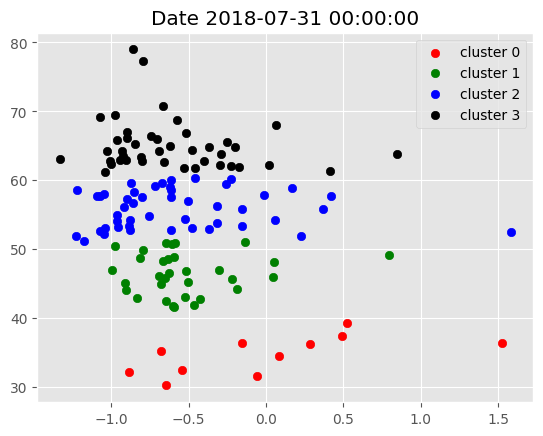

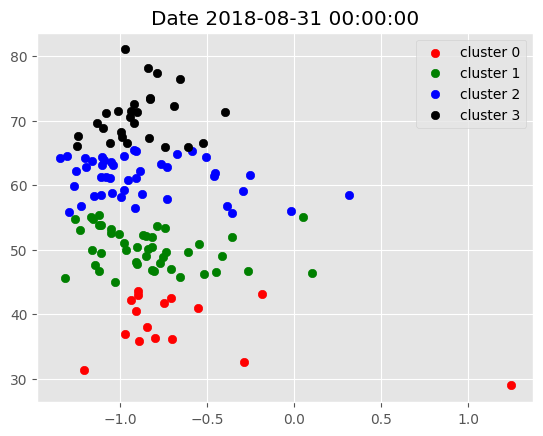

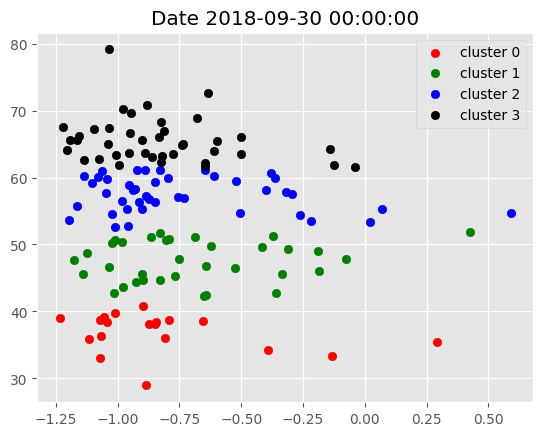

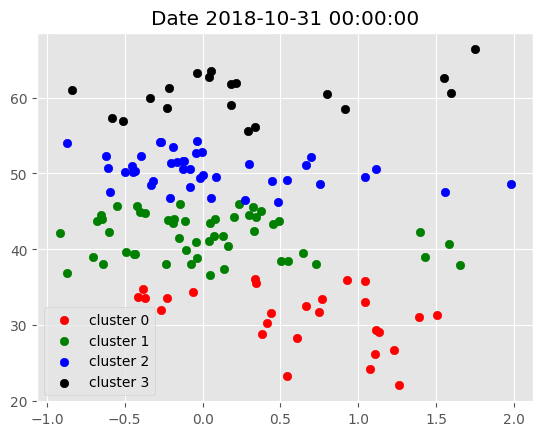

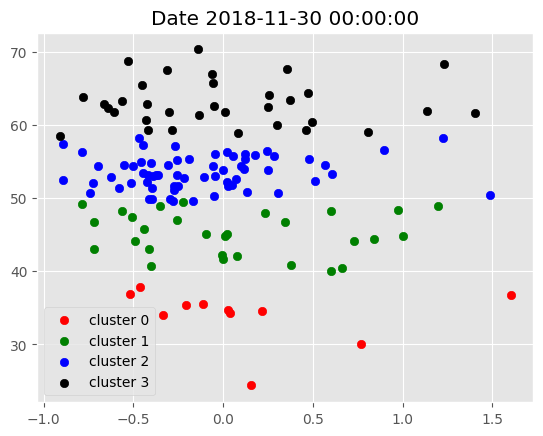

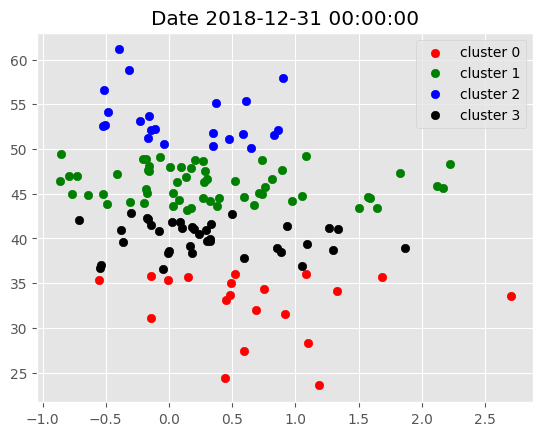

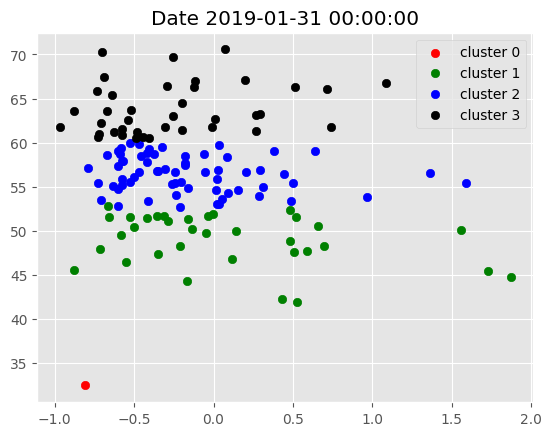

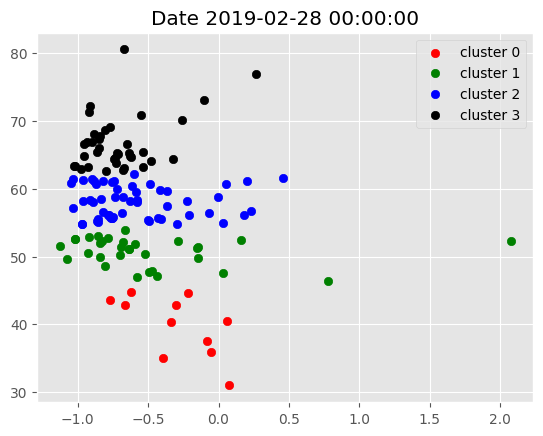

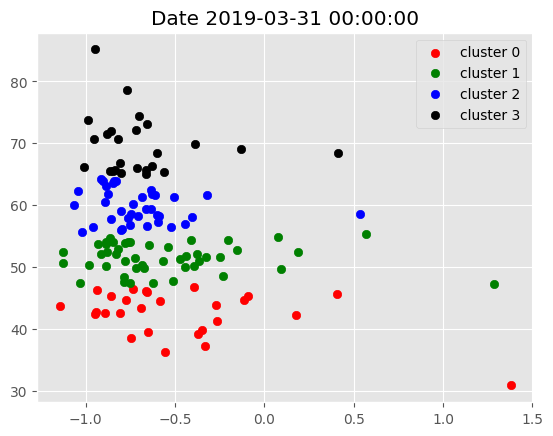

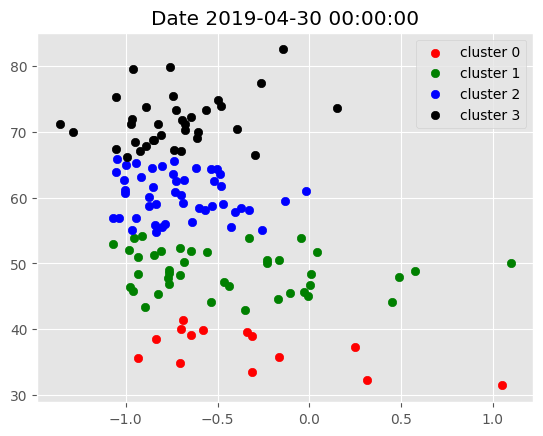

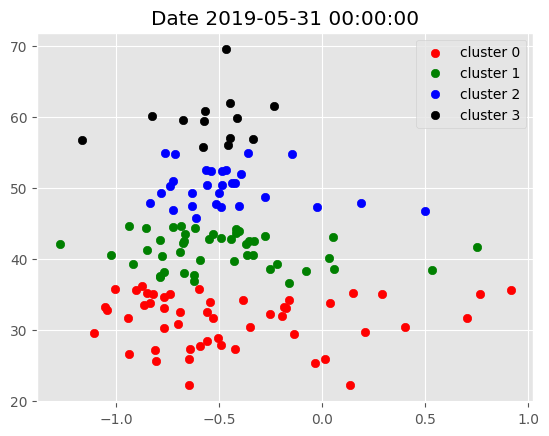

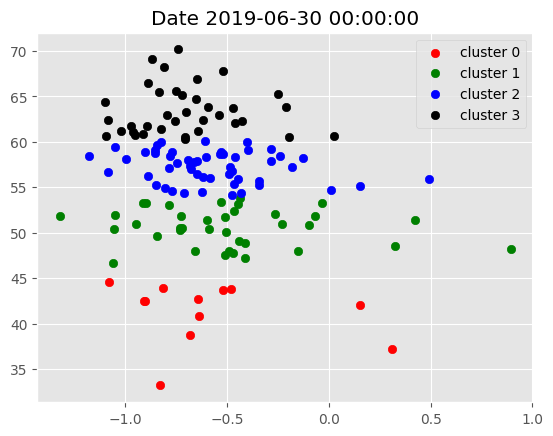

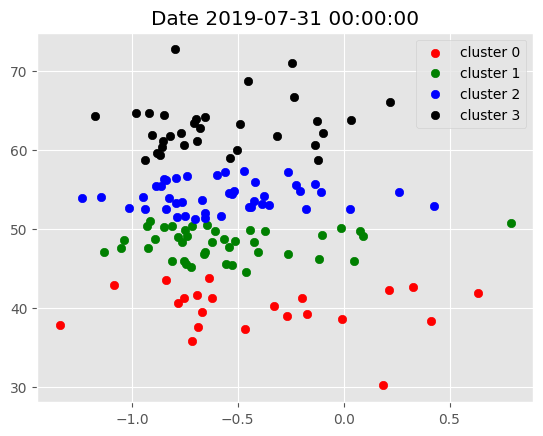

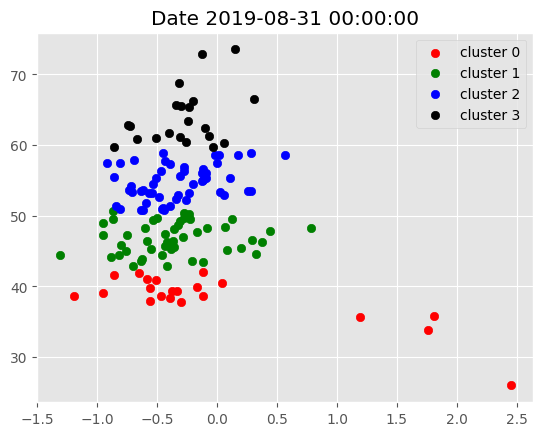

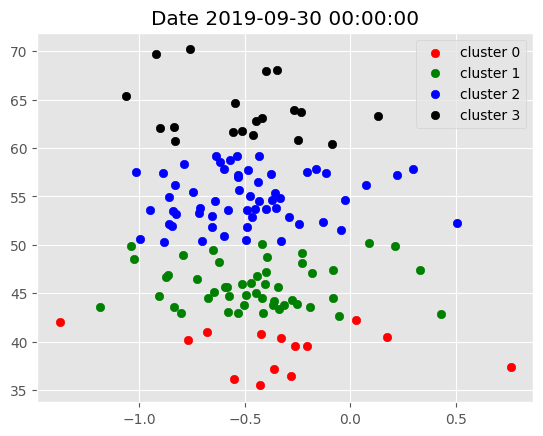

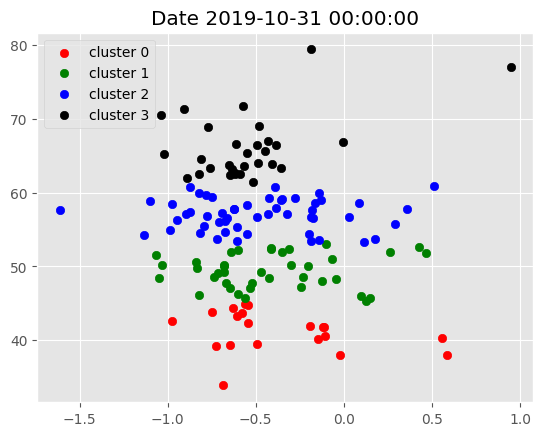

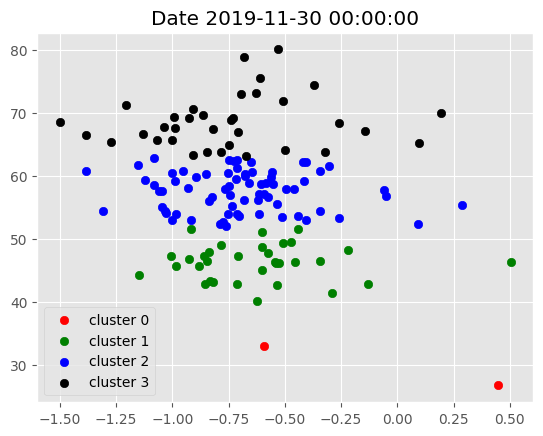

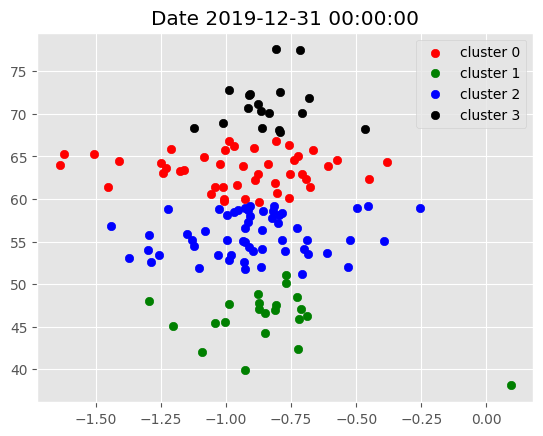

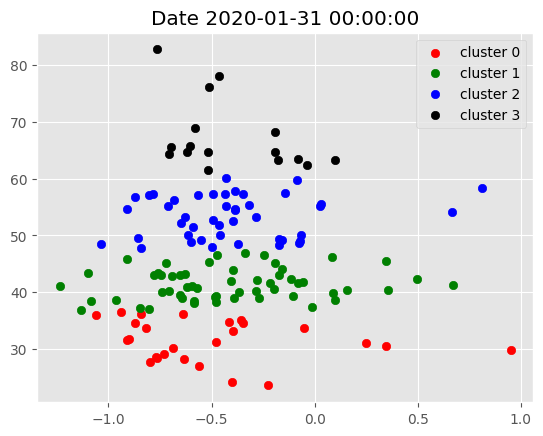

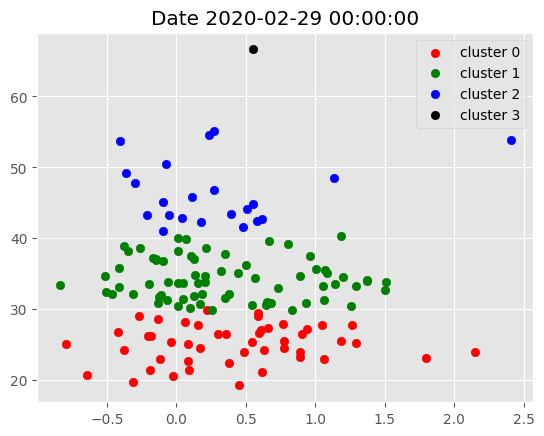

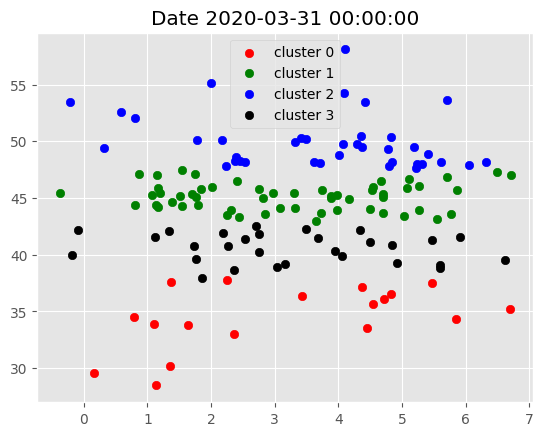

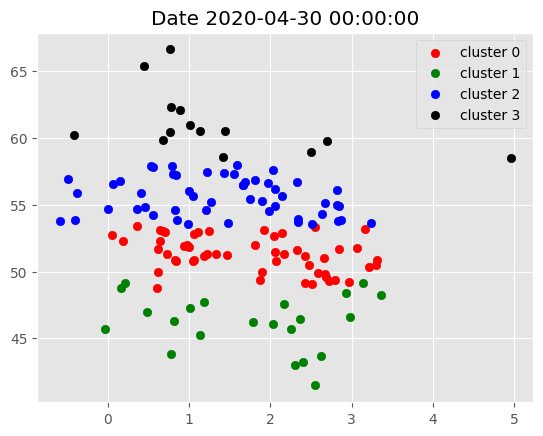

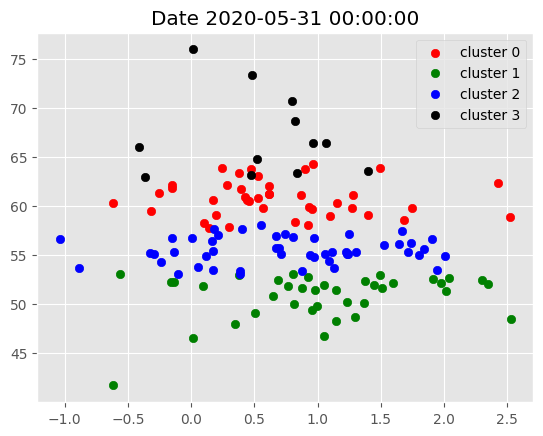

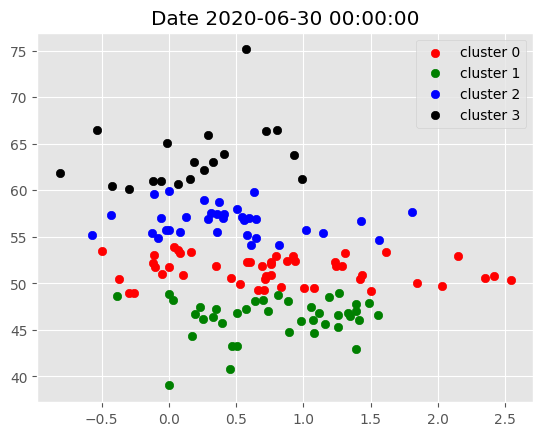

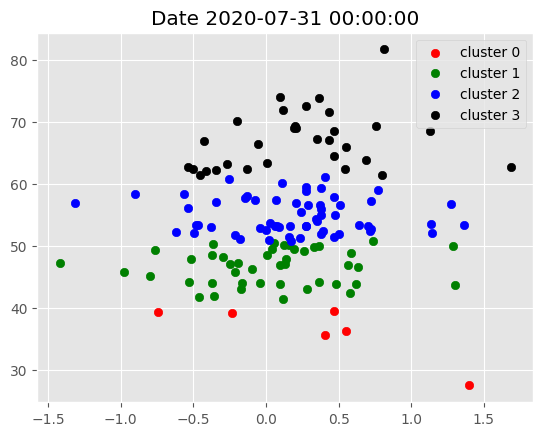

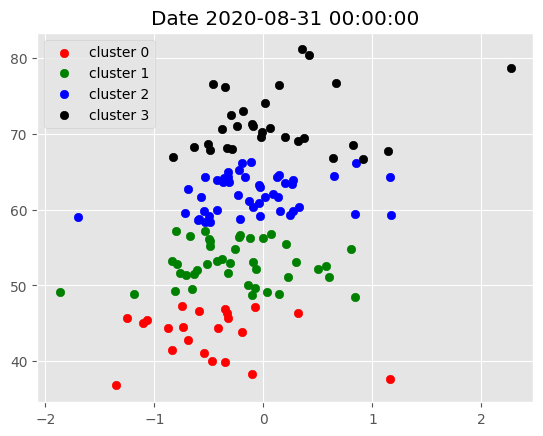

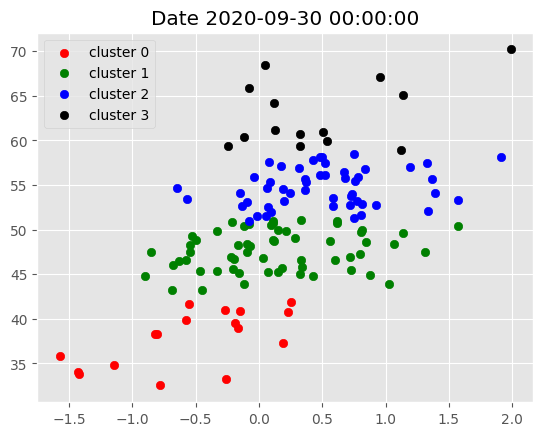

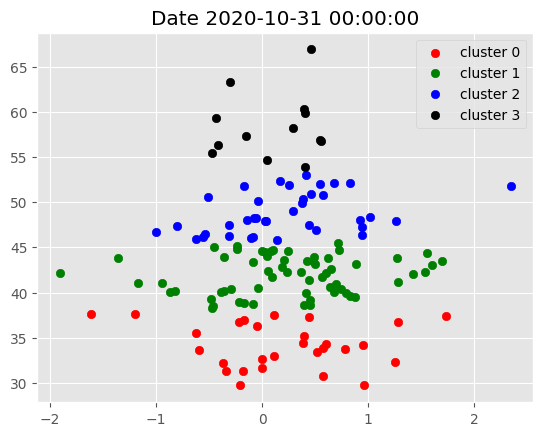

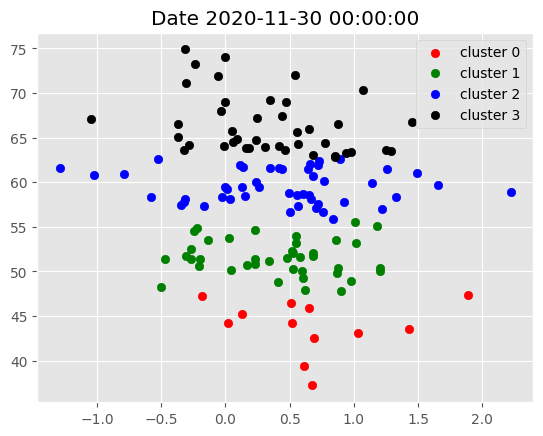

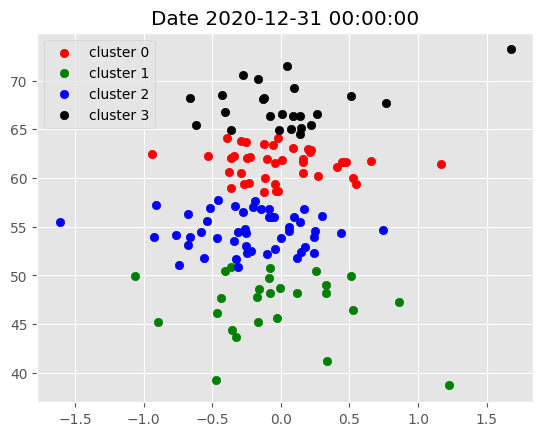

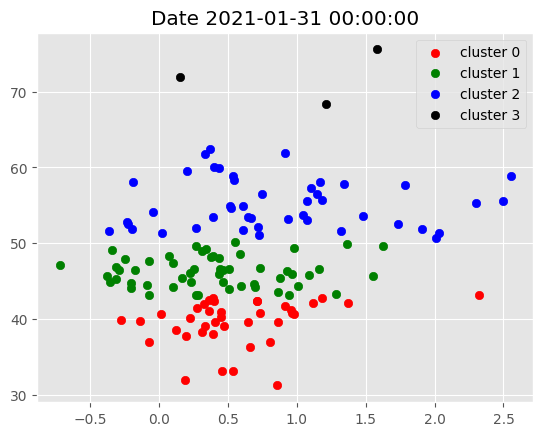

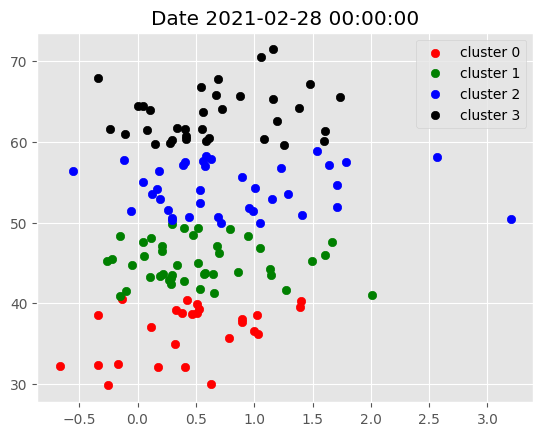

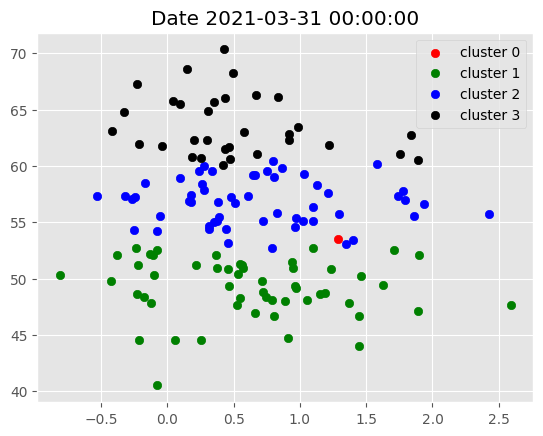

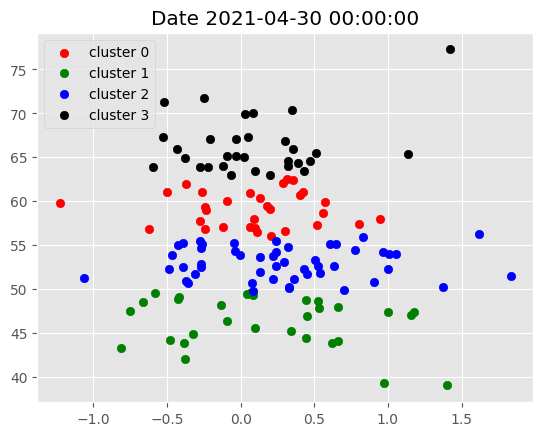

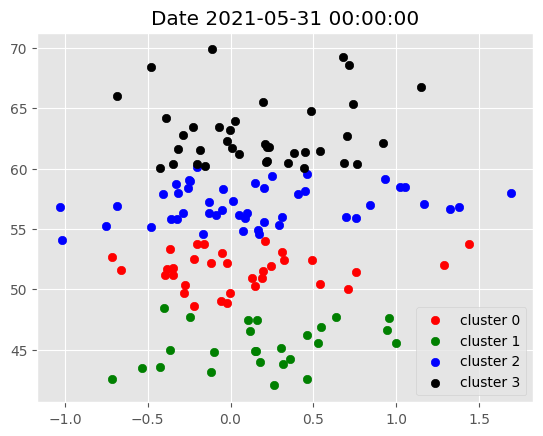

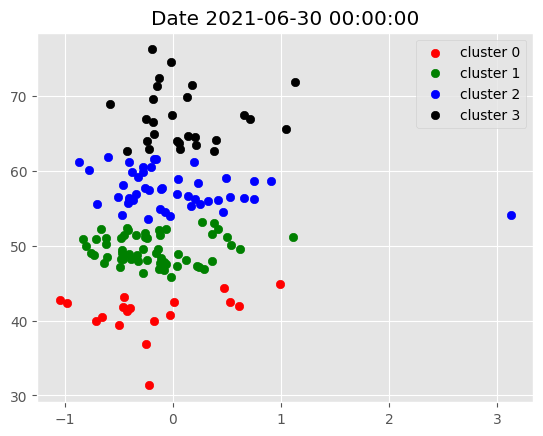

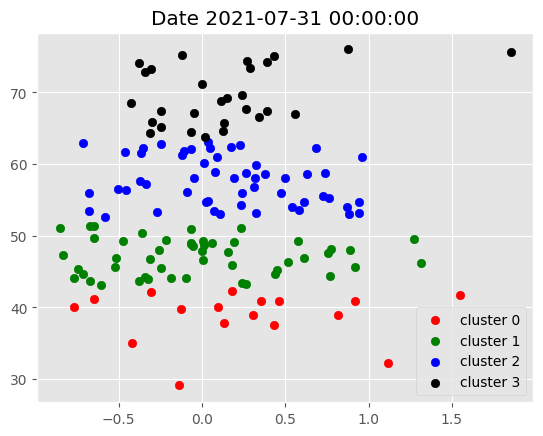

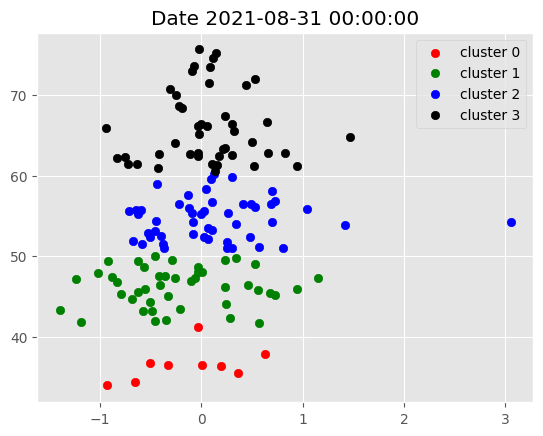

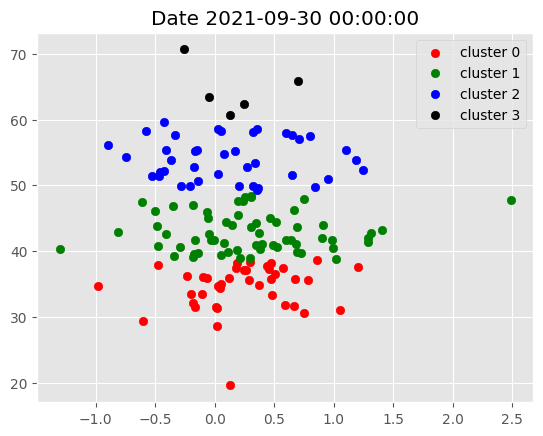

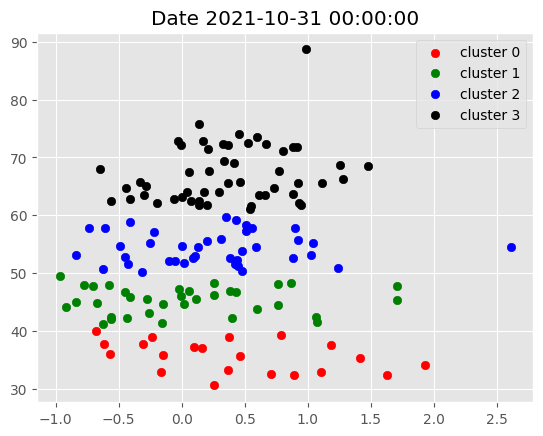

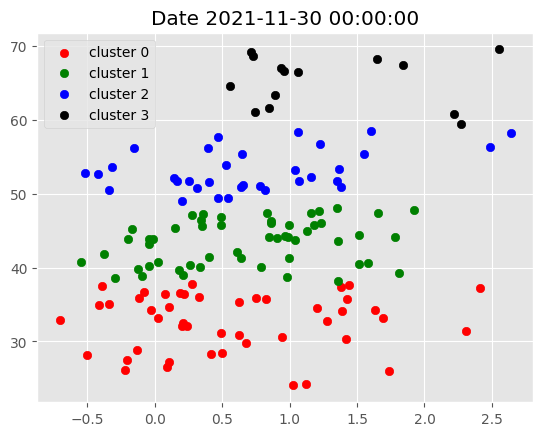

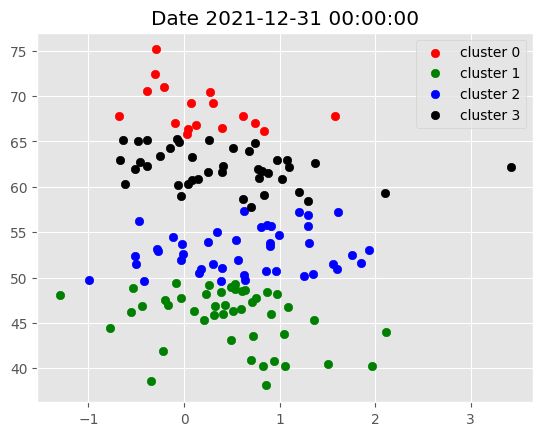

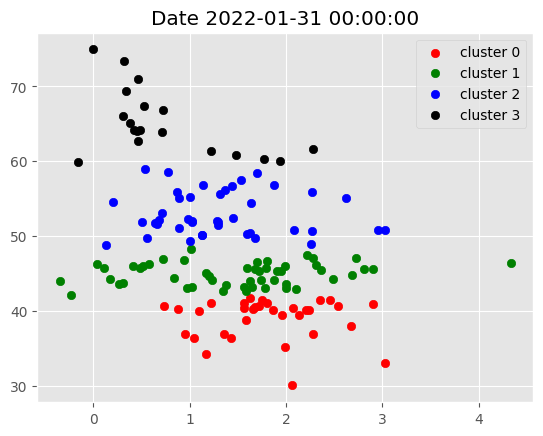

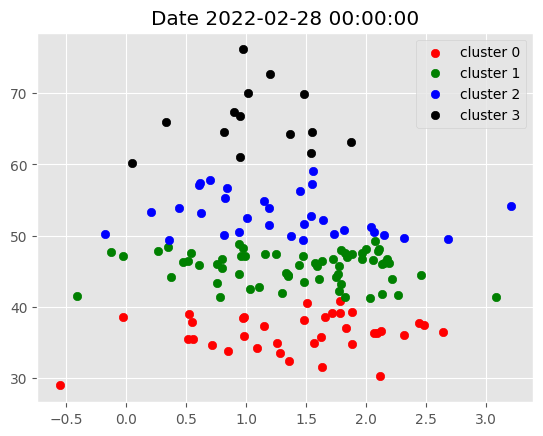

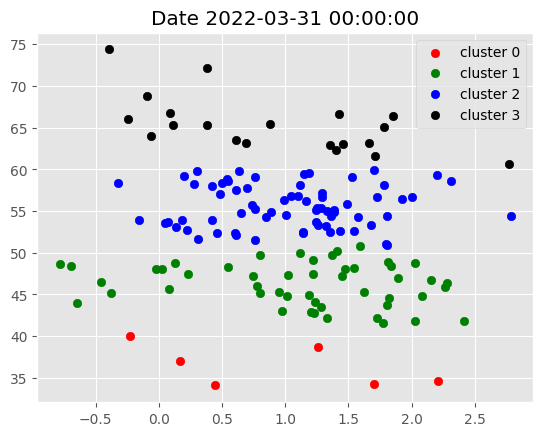

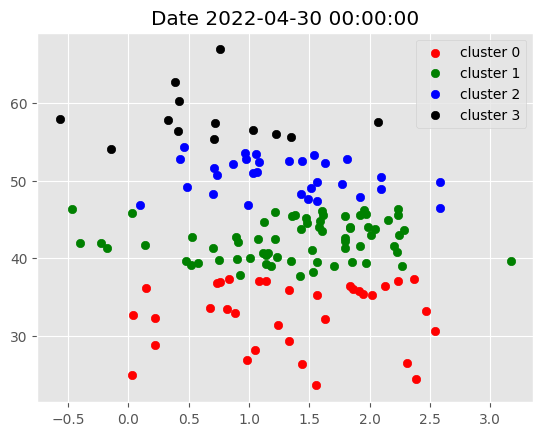

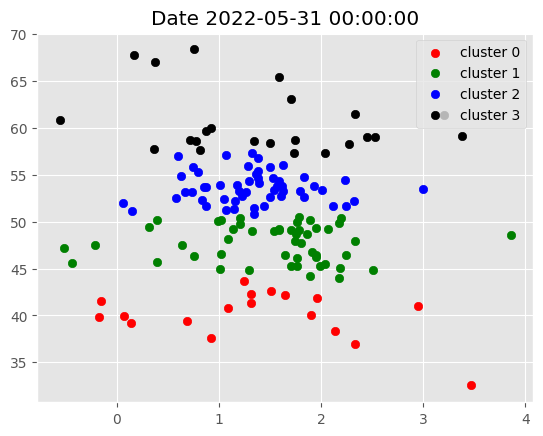

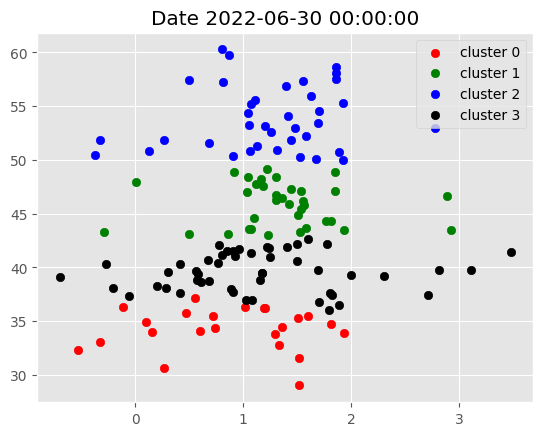

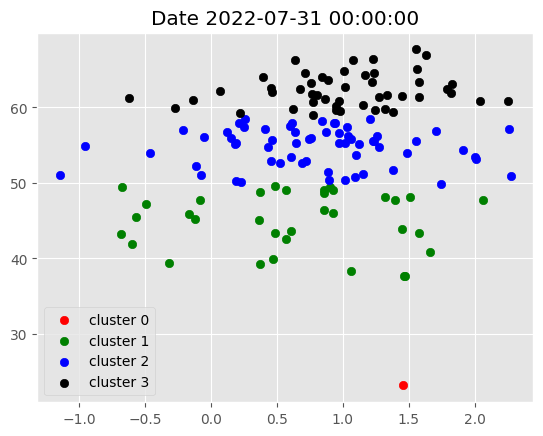

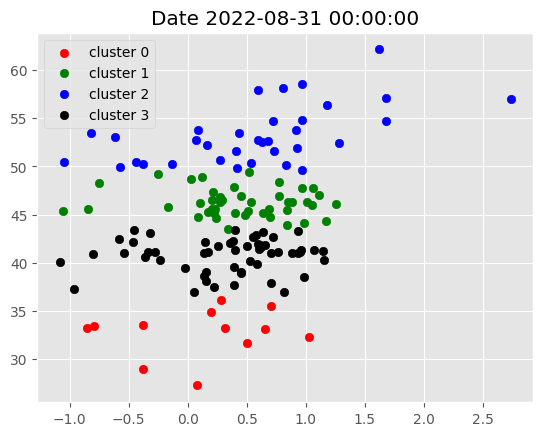

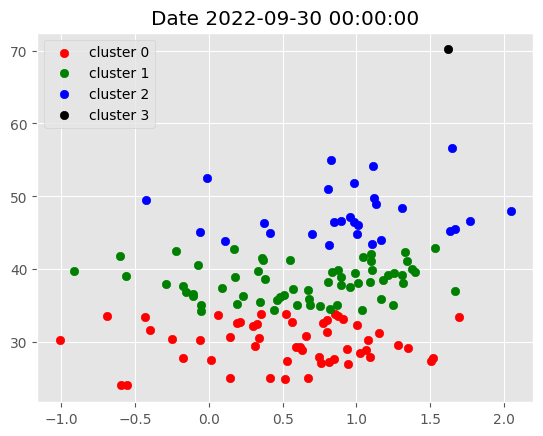

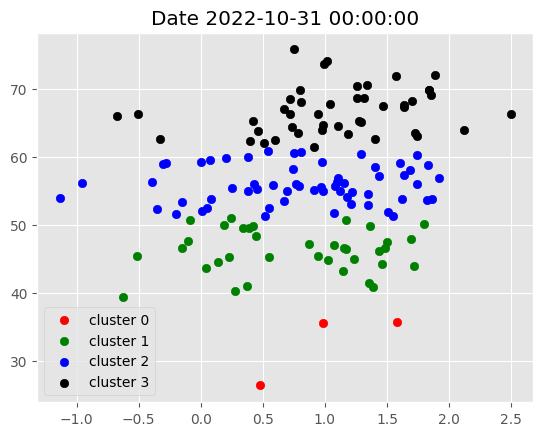

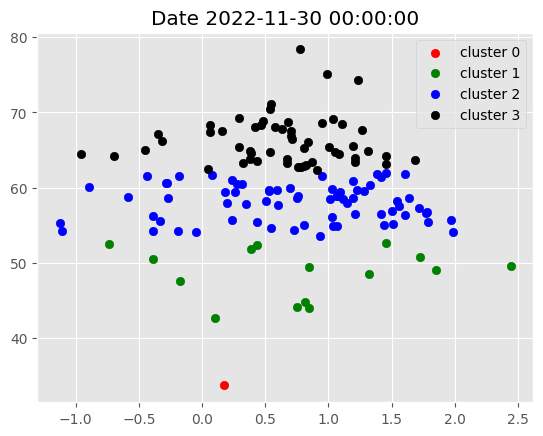

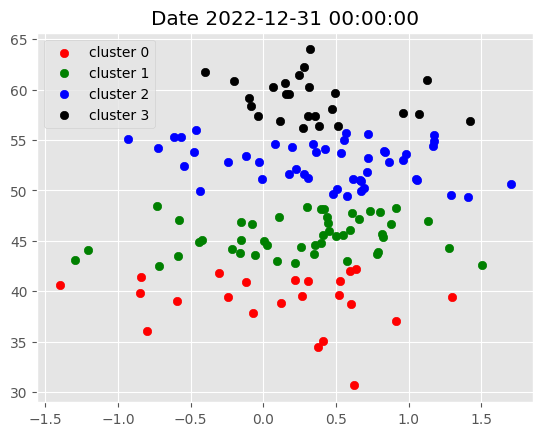

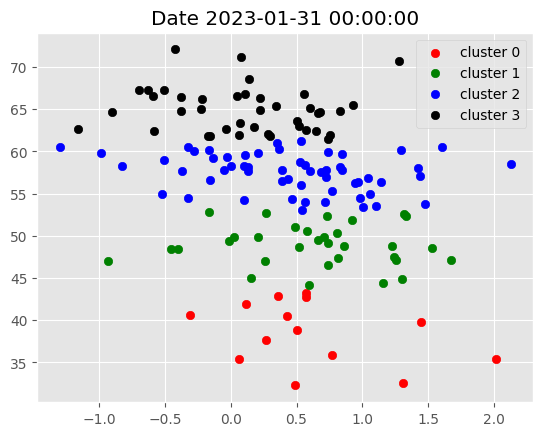

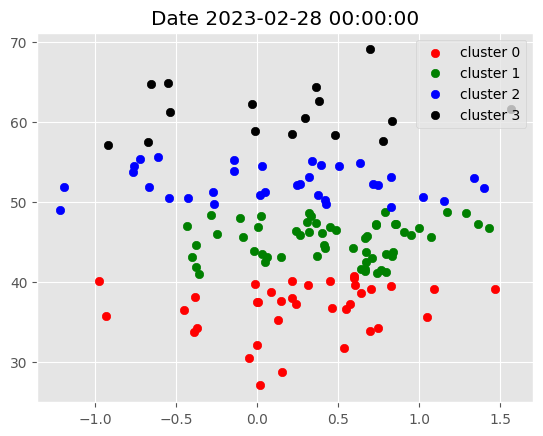

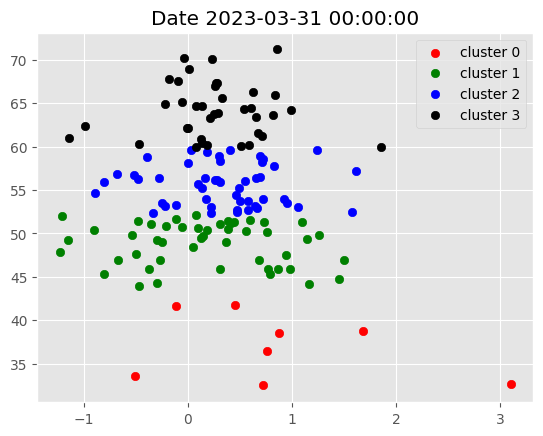

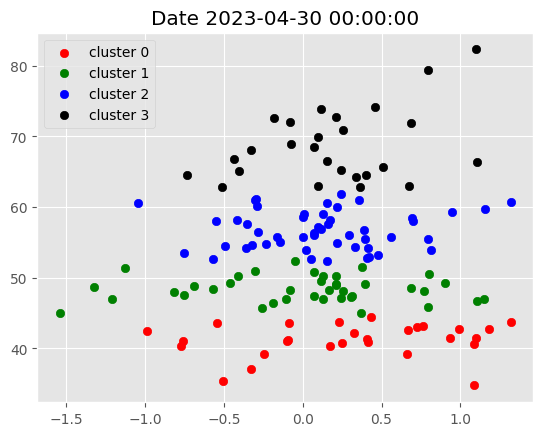

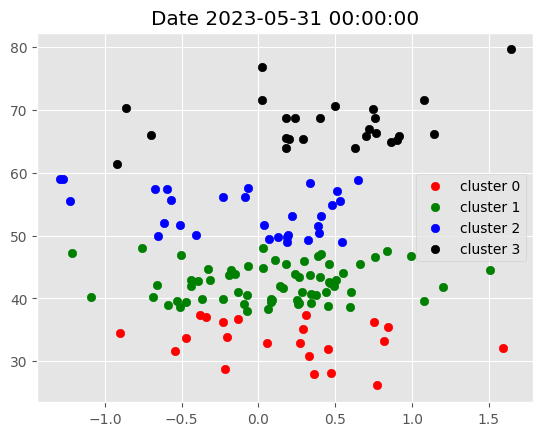

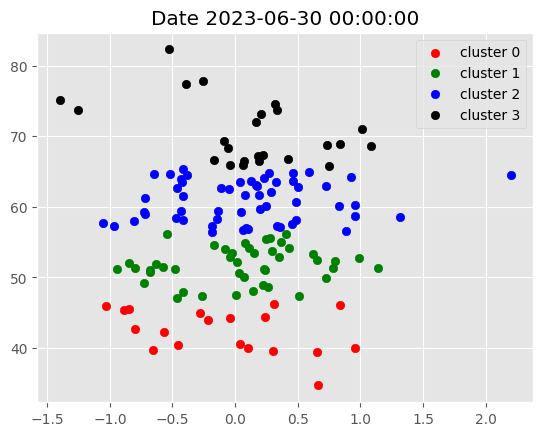

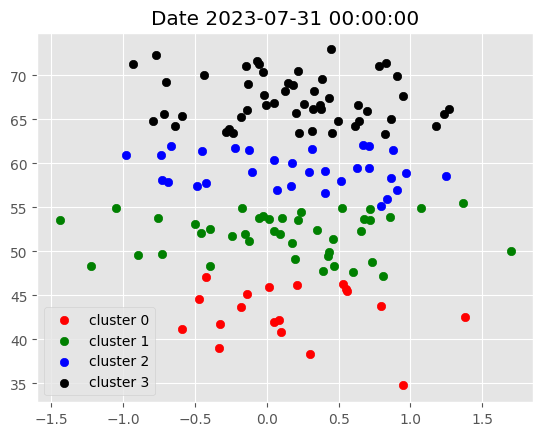

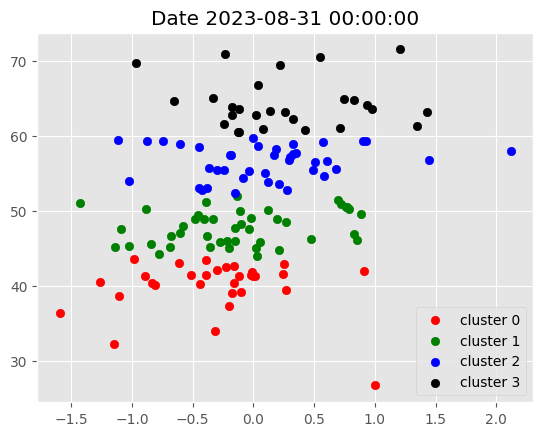

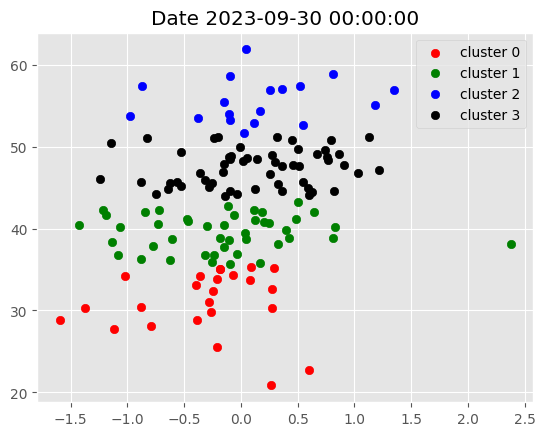

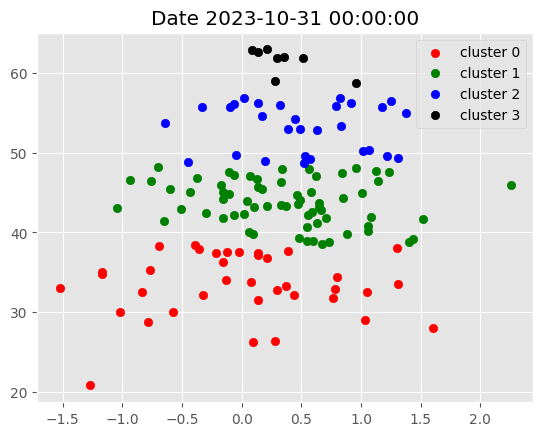

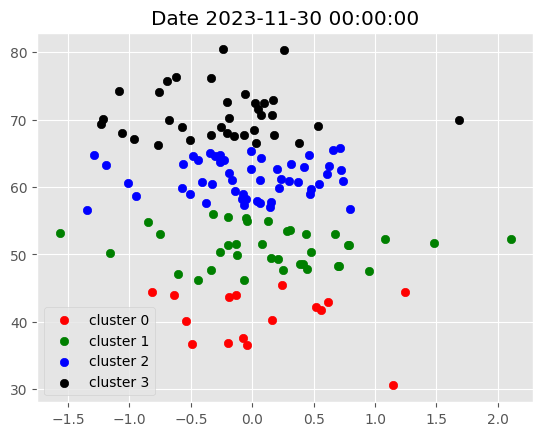

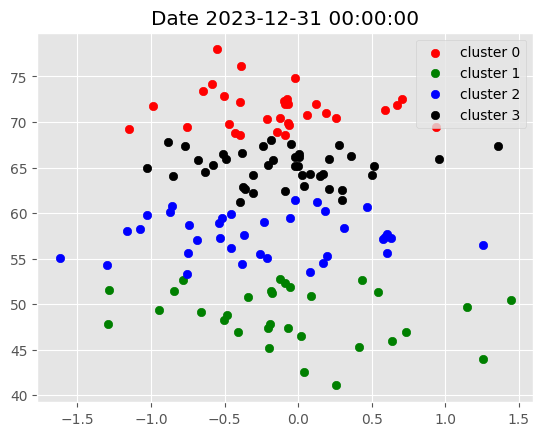

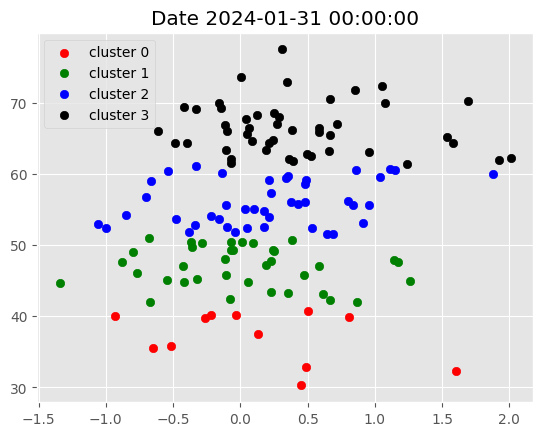

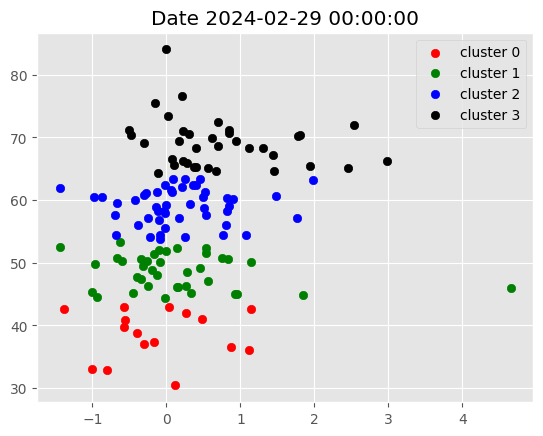

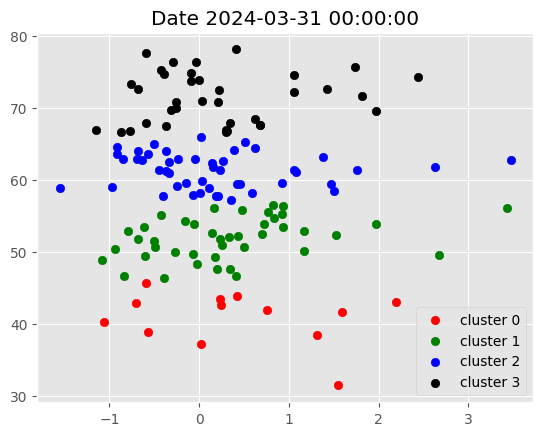

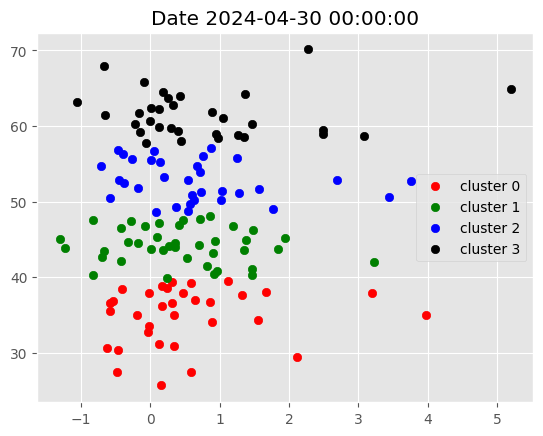

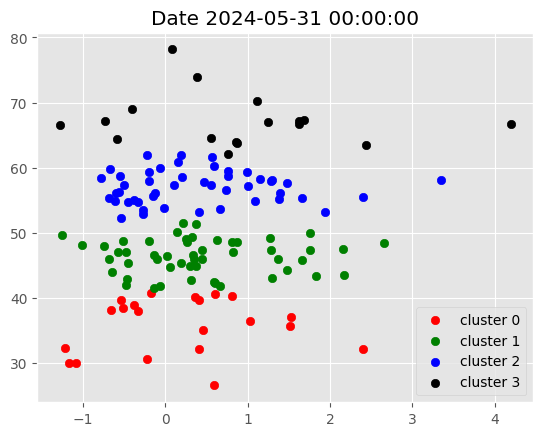

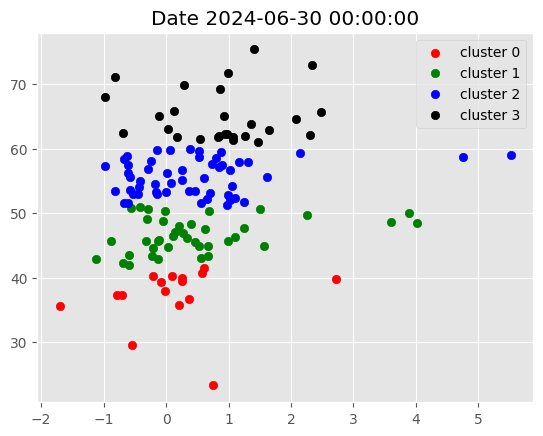

In [214]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i,level=0)
    plt.title(f'Date {i}')
    plot_clusters(g)

### Apply pre-defined centroids

In [211]:
target_rsi_values = [30,45,55,70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 1] = target_rsi_values

initial_centroids

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

applied by changing the previous cells

## Build a portfolio based on Efficient Frontier max sharpe ratio optimization

In [224]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2018-08-01': ['ABT',
  'AMD',
  'AMGN',
  'AMT',
  'BDX',
  'BMY',
  'CMCSA',
  'COST',
  'CSX',
  'DIS',
  'ELV',
  'EOG',
  'EXPE',
  'GILD',
  'HON',
  'JNJ',
  'JPM',
  'KO',
  'LLY',
  'LUV',
  'MDLZ',
  'MDT',
  'MMM',
  'MRK',
  'ORLY',
  'PEP',
  'PFE',
  'PG',
  'PM',
  'QCOM',
  'REGN',
  'RTX',
  'SHW',
  'TGT',
  'TJX',
  'TMO',
  'UAL',
  'UNP',
  'UPS',
  'USB',
  'VLO',
  'WMT'],
 '2018-09-01': ['AAPL',
  'ADP',
  'AMD',
  'AMZN',
  'BDX',
  'COST',
  'CSCO',
  'CVS',
  'DAL',
  'ISRG',
  'LLY',
  'LOW',
  'LUV',
  'MDT',
  'MSFT',
  'NVDA',
  'ORLY',
  'PANW',
  'QCOM',
  'REGN',
  'SHW',
  'TGT',
  'TJX',
  'TMO',
  'UAL',
  'UNH',
  'V'],
 '2018-10-01': ['ABT',
  'ADP',
  'ADSK',
  'AMD',
  'AMGN',
  'AVGO',
  'BA',
  'CAT',
  'COP',
  'CRM',
  'CSCO',
  'CVS',
  'DHR',
  'DIS',
  'ELV',
  'EOG',
  'HON',
  'ISRG',
  'LLY',
  'LMT',
  'LOW',
  'MA',
  'MDT',
  'MRK',
  'MSFT',
  'ORCL',
  'ORLY',
  'OXY',
  'PFE',
  'RTX',
  'SBUX',
  'TGT',
  'TJX',
  'TMO',
  'TMU

### Portfolio Optimization Function

In [235]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [361]:
def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252) # 252 days - one year of trading data
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

In [362]:
# downlaoding fresh daily prices data

stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  155 of 155 completed


Price       Adj Close                                                  \
Ticker            AAL        AAPL        ABBV         ABT         ACN   
Date                                                                    
2017-07-31  48.955448   34.805626   51.445625   43.532558  115.462799   
2017-08-01  49.557201   35.114536   51.791473   43.506016  116.394966   
2017-08-02  48.965157   36.773731   52.034328   43.576817  115.283524   
2017-08-03  49.062214   36.406326   52.240356   43.514858  116.538406   
2017-08-04  49.304852   36.598213   52.240356   43.603371  116.699715   
...               ...         ...         ...         ...         ...   
2024-06-24  11.160000  208.139999  171.167618  104.744308  305.868591   
2024-06-25  11.130000  209.070007  169.195724  104.933296  305.828796   
2024-06-26  11.120000  213.250000  169.592072  104.326515  303.289917   
2024-06-27  11.280000  214.100006  167.451752  104.097733  301.866150   
2024-06-28  11.330000  210.619995  169.958725  103.361641  302.085205   

Price                                                                  ...  \
Ticker            ADBE         ADI         ADP        ADSK        AIG  ...   
Date                                                                   ...   
2017-07-31  146.490005   69.072258  102.579735  110.790001  54.342331  ...   
2017-08-01  147.360001   69.019791  100.742249  111.379997  54.367260  ...   
2017-08-02  147.130005   68.906128   99.422348  109.129997  54.715984  ...   
2017-08-03  147.789993   68.136841   96.420296  107.879997  54.848827  ...   
2017-08-04  147.710007   67.996956   96.092476  108.389999  54.035145  ...   
...                ...         ...         ...         ...        ...  ...   
2024-06-24  524.169983  228.460007  249.199997  239.169998  76.010002  ...   
2024-06-25  526.880005  230.339996  248.399994  242.529999  74.510002  ...   
2024-06-26  528.659973  227.839996  238.020004  243.279999  74.489998  ...   
2024-06-27  546.760010  226.679993  237.300003  243.679993  74.970001  ...   
2024-06-28  555.539978  228.259995  238.690002  247.449997  74.239998  ...   

Price         Volume                                                   \
Ticker             V      VLO     VRTX        VZ        WBA       WDC   
Date                                                                    
2017-07-31   7576600  7354800  2972700  28456800    4853500   5093600   
2017-08-01   6018100  5330100  1621100  33498200    4892600   4010000   
2017-08-02   5955600  3724900  1781700  19233400    4216400   3757500   
2017-08-03   5697500  3342700  1407100  15190100    4666500   3511100   
2017-08-04   4618000  3201800   807800  13841700    3777300  10704300   
...              ...      ...      ...       ...        ...       ...   
2024-06-24  24149600  2851300  1188600  20773800   13632500   5122600   
2024-06-25  19897700  4862900  1195800  18933000   10336600   3764400   
2024-06-26  12172000  3843100  1272300  19709900   12933400   3663400   
2024-06-27  10529100  2540100   959600  15560800  132813000   4344900   
2024-06-28  13957300  3898900  3234600  27639200   54346500   8582800   

Price                                              
Ticker           WFC       WMT     WYNN       XOM  
Date                                               
2017-07-31  20378100  18789600  2475300  12820200  
2017-08-01  19350300  17179500  2424100  10421200  
2017-08-02  19422100  26019000  2906300  10410100  
2017-08-03  19374700  29840700  1238600  10136700  
2017-08-04  44664600  21425400  1034400   8292200  
...              ...       ...      ...       ...  
2024-06-24  16198300  12470400  1828400  16266700  
2024-06-25  27490700  20904000  1489200  16213700  
2024-06-26  30425700  14177500  1089700  15771800  
2024-06-27  13832200  12899200  1266600  16812700  
2024-06-28  31074500  18816700  2199400  24565900  

[1740 rows x 930 columns]

In [422]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        
        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df.loc[optimization_start_date:optimization_end_date]['Adj Close'][cols]

        weights = optimize_weights(prices = optimization_df, 
                               lower_bound = round(1/(len(optimization_df.columns)*2),3))

        weights = pd.DataFrame(weights, index=pd.Series(0))

        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                       left_index=True,
                       right_index=True)\
                .reset_index().set_index(['Date', 'Ticker']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Startegy Return')

        portfolio_df = pd.concat([portfolio_df,temp_df], axis=0) 
        
    except Exception as e:
        print(e)

('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
at least one of the assets must have an expected return exceeding the risk-free rate
('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
at least one of the assets must have an expected return exceeding the risk-free rate
('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
'return'


In [423]:
portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

,Startegy Return
date,
2018-08-01,-0.008689
2018-08-02,0.005880
2018-08-03,0.002622
2018-08-06,0.003596
2018-08-07,0.003811
...,...
2024-06-24,-0.007780
2024-06-25,0.008048
2024-06-26,-0.000920


## Visualize Portfolio returns and compare to SP500 returns

In [424]:
spy = yf.download(tickers='SPY',
                  start='2016-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,Startegy Return,SPY Buy&Hold
2018-08-01,-0.008689,-0.001672
2018-08-02,0.005880,0.005433
2018-08-03,0.002622,0.004276
2018-08-06,0.003596,0.003660
2018-08-07,0.003811,0.003297
...,...,...
2024-06-24,-0.007780,-0.003256
2024-06-25,0.008048,0.003843
2024-06-26,-0.000920,0.001247
2024-06-27,-0.003634,0.001575


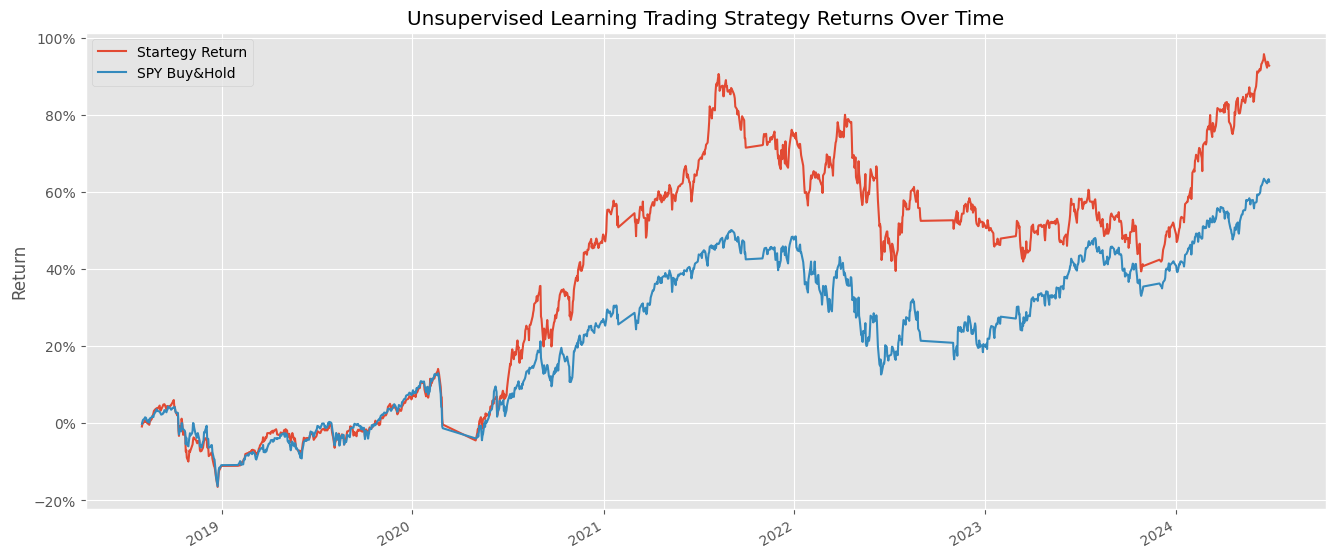

In [426]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2024-06-30'].plot(figsize=(16,7))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()